<a href="https://colab.research.google.com/github/bogomolga/VersionControl_Seminar3/blob/main/%D0%9C%D0%B0%D1%80%D0%B0%D1%84%D0%BE%D0%BD_%D0%A3%D0%98%D0%98_%7C_%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title сервисные функции
!pip -q install tabulate
import gdown
import pandas as pd  
from keras import backend as K
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential , Model, load_model
# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, GlobalMaxPooling1D, Embedding, Flatten, Activation, LeakyReLU, Input, concatenate, add, multiply

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import utils
# Заполнение последовательностей до определенной длины
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt 
# Кодирование тестовых меток
from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    
class Worker:
  url_ds = 'https://storage.yandexcloud.net/aiueducation/Content/base/l10/moscow.csv'
  url_voc = 'https://storage.yandexcloud.net/aiueducation/marketing/marathon/new_voc.pickle'
  url_sets = 'https://storage.yandexcloud.net/aiueducation/marketing/marathon/sets.zip'

  def __init__(self):
    self.df = None
  def load_data(self):
    print(f'{bcolors.BOLD}Загрузка датасета:', end='')
    fname = gdown.download(self.__class__.url_ds, None, quiet=True)    
    self.df = pd.read_csv(fname,  sep=";")
    self.df = self.df.iloc[::2,:] #Выбираем нечётные строки, в чётных строках в исходном фрейме пустые строки для комментариев    
    self.df = self.df[self.df['Комнат']=='1']
    self.df.drop(['ГРМ',	'Бонус агенту',	'Дата',	'Кол-во дней в экспозиции',	'Источник'], inplace=True, axis=1)
    self.df.dropna(axis=0, inplace=True)
    voc_pickle = gdown.download(self.__class__.url_voc, None, quiet=True)
    # Открываем файл для чтения
    with open(voc_pickle, "rb") as f:
        # Загружаем словарь из файла
        self.voc = pickle.load(f)
    print(f'{bcolors.OKGREEN} Done {bcolors.ENDC}')
    print()
    print(f'{bcolors.BOLD}Информация о датасете:{bcolors.ENDC}')
    print(f'  {bcolors.OKBLUE}размер:{bcolors.ENDC} {self.df.shape[0]} записей')
    print()    
    print(f'5 cлучайных примеров:')
    sample = self.df.sample(5)
    display(sample.head())
    
  def create_sets(self):
    print(f'{bcolors.BOLD}Создание обучающей и проверочной выборки:', end='')
    archive = gdown.download(self.__class__.url_sets, None, quiet=True)
    !rm -rf /content/sets
    !unzip -q {archive} -d /content/sets

    xTrainEmb = np.load('sets/xTrainEmb.npy',)
    yTrain = np.load('sets/yTrain.npy',)
    xTrainScaled = np.load('sets/xTrainScaled.npy',)

    self.x_train_num, self.x_test_num, self.x_train_emb, self.x_test_emb, self.y_train, self.y_test = train_test_split(
        xTrainScaled,
        xTrainEmb,
        yTrain,
        test_size=0.2,        
        shuffle=True,
        random_state=2,)

    print(f'{bcolors.OKGREEN} Done {bcolors.ENDC}')
    print()
    print(f'{bcolors.BOLD}Размеры сформированных выборок:{bcolors.ENDC}')
    print(f'  обучающая выборка (числовые данные)', self.x_train_num.shape)
    print(f'  обучающая выборка (текстовые данные)', self.x_train_emb.shape)
    print(f'  обучающая выборка (цена квартиры)', self.y_train.shape)
    print()
    print(f'  проверочная выборка (числовые данные)', self.x_test_num.shape)
    print(f'  проверочная выборка (текстовые данные)', self.x_test_emb.shape)
    print(f'  проверочная выборка (цена квартиры)', self.y_test.shape)

  def plot_graphic(self, history):
    # Визуализация результатов
    f, ax = plt.subplots(1,2, figsize=(30, 8))
    ax[0].plot(history.history['loss'], label='Среднеквадратичная ошибка на обучающем наборе')
    ax[0].plot(history.history['val_loss'], label='Среднеквадратичная ошибка на проверочном наборе')
    ax[0].set_ylabel('Средняя ошибка')
    ax[0].set_xlabel('Эпоха обучения')
    ax[1].plot(history.history['mae'], label='Средняя абсолютная ошибка на обучающем наборе')
    ax[1].plot(history.history['val_mae'], label='Средняя абсолютная ошибка на проверочном наборе')
    ax[1].set_ylabel('Абсолютная ошибка')
    ax[1].set_xlabel('Эпоха обучения')
    plt.show()

  def demonstration_FAPI(self, model, sample, txt_data, min_index = -1):
    inp = model.input
    for i, layer in enumerate(model.layers):
      if i<min_index:
        continue
      type_layer = layer.__class__.__name__
      outputs = layer.output
      functors = K.function([inp], [outputs])
      layer_outs = functors(sample)      
      if type_layer=='Dense':
        cnt_units = layer.get_weights()[0].shape[1]        
        print(f'Значения поступают на {bcolors.OKBLUE}{i+1}-й слой{bcolors.ENDC} ({type_layer}), содержащий {bcolors.BOLD} {cnt_units} нейронов{bcolors.ENDC}')      
        print(f'На выходе слоя получаем вектор из {cnt_units} значений:')
        weights = layer_outs[0][0]
        data = [weights[i:i+10] for i in range(0, weights.shape[0], 10)]
        print(tabulate(data, tablefmt="grid"))
        res = layer_outs[0][0]
        print()
        print()
      elif type_layer=='BatchNormalization':
        print(f'Значения поступают на {bcolors.OKBLUE}{i+1}-й слой{bcolors.ENDC} ({type_layer}){bcolors.ENDC}')
        res = layer_outs[0][0]
        print(f'На выходе слоя получаем вектор из {res.shape[0]} значений:')
        weights = layer_outs[0][0]
        data = [weights[i:i+10] for i in range(0, weights.shape[0], 10)]
        print(tabulate(data, tablefmt="grid"))
        print()
        print()
      elif type_layer=='Embedding':
        print(f'Значения поступают на {bcolors.OKBLUE}{i+1}-й слой{bcolors.ENDC} ({type_layer}){bcolors.ENDC}')
        res = layer_outs[0][0]
        print(f'На выходе слоя получаем {res.shape[0]} векторов(а), состоящих из {res.shape[1]} значений:')
        weights = layer_outs[0][0]
        #data = [weights[i:i+10] for i in range(0, weights.shape[0], 10)]
        headers = ["Слово", "Индекс", "Embedding представление"]
        table = [[txt_data[i], sample[1][0][i], weights[i]] for i in range(len(sample[1][0]))]
        print(tabulate(table, headers, tablefmt="grid"))
        print()
        print()
      elif type_layer=='Dropout':
        print(f'Слой {bcolors.BOLD} Dropout{bcolors.ENDC}. Используется только при обучении модели')
        print()
      elif type_layer=='SpatialDropout1D':
        print(f'Слой {bcolors.BOLD} SpatialDropout1D{bcolors.ENDC}. Используется только при обучении модели')
        print('Слой на каждом батче обучения отключает (обнуляет) случайным образом каждую строку входных данных')
        print('При использовании сразу после Embedding-слоя будут отключаться вектора, соответствующие слову в исходном тексте')
        print()
      elif type_layer=='Activation':
        print(f'Значения поступают на {bcolors.OKBLUE}{i+1}-й слой{bcolors.ENDC} ({type_layer}), который применяет активационную функцию к входным данным')      
        res = layer_outs[0][0]
        print(f'На выходе слоя получаем вектор из {res.shape[0]} значений:')
        weights = layer_outs[0][0]
        if len(weights)>64:
          data = [weights[:20]]
          print(tabulate(data, tablefmt="grid"))
          print('................')
          data = [weights[-20:]]
          print(tabulate(data, tablefmt="grid"))
        else:
          weights = layer_outs[0][0]
          data = [weights[i:i+10] for i in range(0, weights.shape[0], 10)]
          print(tabulate(data, tablefmt="grid"))
        print()
        print()
      elif type_layer=='LeakyReLU':
        print(f'Значения поступают на {bcolors.OKBLUE}{i+1}-й слой{bcolors.ENDC} ({type_layer}), который применяет активационную функцию LeakyReLU к входным данным')      
        res = layer_outs[0][0]
        print(f'На выходе слоя получаем вектор из {res.shape[0]} значений:')
        weights = layer_outs[0][0]
        if len(weights)>64:
          data = [weights[:20]]
          print(tabulate(data, tablefmt="grid"))
          print('................')
          data = [weights[-20:]]
          print(tabulate(data, tablefmt="grid"))
        else:
          weights = layer_outs[0][0]
          data = [weights[i:i+10] for i in range(0, weights.shape[0], 10)]
          print(tabulate(data, tablefmt="grid"))
        print()
        print() 
      
      elif type_layer.lower() in ['concatenate', 'add', 'multiply']:
        print(f'Значения поступают на {bcolors.OKBLUE}{i+1}-й слой{bcolors.ENDC} ({type_layer}), который производит объединение слоев')      
        res = layer_outs[0][0]
        print(f'На выходе слоя получаем вектор из {res.shape[0]} значений:')
        weights = layer_outs[0][0]
        if len(weights)>64:
          data = [weights[:20]]
          print(tabulate(data, tablefmt="grid"))
          print('................')
          data = [weights[-20:]]
          print(tabulate(data, tablefmt="grid"))
        else:
          weights = layer_outs[0][0]
          data = [weights[i:i+10] for i in range(0, weights.shape[0], 10)]
          print(tabulate(data, tablefmt="grid"))
        print()
        print()        
      elif type_layer=='Flatten' or type_layer=='GlobalMaxPooling1D' or type_layer=='GlobalAveragePooling1D':
        print(f'Значения поступают на {bcolors.OKBLUE}{i+1}-й слой{bcolors.ENDC} ({type_layer}), который выполняет развертывание всех данных в один вектор')      
        res = layer_outs[0][0]
        print(f'На выходе слоя получаем вектор из {res.shape[0]} значений:')
        weights = layer_outs[0][0]
        if len(weights)>64:
          data = [weights[:20]]
          print(tabulate(data, tablefmt="grid"))
          print('................')
          data = [weights[-20:]]
          print(tabulate(data, tablefmt="grid"))
        else:
          weights = layer_outs[0][0]
          data = [weights[i:i+10] for i in range(0, weights.shape[0], 10)]
          print(tabulate(data, tablefmt="grid"))
        print()
        print()
    return res

  def get_merge_index(self):
    for i, layer in enumerate(self.model.layers):
      type_layer = layer.__class__.__name__
      if type_layer.lower() in ['concatenate', 'add', 'multiply']:
        return i
    return -1

  def get_premerge_indexes(self, merge_layer_index):
    input_layers = self.model.layers[:merge_layer_index]  # слои, соответствующие входам модели
    merge_layer = self.model.layers[merge_layer_index]   # слой concatenate

    # получение индексов слоев, которые являются входными для слоя concatenate
    input_indexes = []
    for i, layer in enumerate(merge_layer._inbound_nodes[0].inbound_layers):
        if layer in input_layers:
            input_indexes.append(input_layers.index(layer))

    return input_indexes

  def layers_demonstration_API(self, model):  
    self.model=model
    print(f'{bcolors.BOLD}{bcolors.OKBLUE}Демонстрация работы слоев модели{bcolors.ENDC}')
    inp = model.input
    print(f'Нейронная сеть имеет два входа. \n  Размерность первого входа: {inp[0].shape[1]} элементов \n  Размерность второго входа: {inp[1].shape[1]} элементов')
    print(f'Для примера возьмем случайную запись из тестовой выборки.')    
    idx = np.random.choice(self.x_train_num.shape[0])
    sample = [self.x_train_num[idx][None,...], self.x_train_emb[idx][None,...]]
    answer = self.y_train[idx]
    print(f'{bcolors.BOLD}Текстовое описание:\n {bcolors.ENDC}')
    text_data = [self.voc.get(i,'') for i in sample[1][0]]    
    s = ' '.join(text_data)
    s = ' '.join(s.split())
    print(s)
    print(f'{bcolors.BOLD}Цена: {bcolors.ENDC} {self.y_train[idx]}')
    print()    
    print()
    print(f'{bcolors.BOLD}Работа нейронной сети{bcolors.ENDC}')
    print()
    merge_layer_index = self.get_merge_index()
    premerge_layers_indexes = self.get_premerge_indexes(merge_layer_index)

    # Создаем модели для выхода каждого слоя
    dense1_model = Model(inputs=model.inputs, outputs=model.layers[premerge_layers_indexes[0]].output)
    emb_model = Model(inputs=model.inputs, outputs=model.layers[premerge_layers_indexes[1]].output)

    print(f'{bcolors.BOLD} {bcolors.OKGREEN} -ПЕРВЫЙ ВХОД МОДЕЛИ {bcolors.ENDC}')
    res_1 = self.demonstration_FAPI(dense1_model, sample, text_data)

    print(f'{bcolors.BOLD} {bcolors.OKGREEN} -ВТОРОЙ ВХОД МОДЕЛИ {bcolors.ENDC}')
    res_2 = self.demonstration_FAPI(emb_model, sample, text_data)

    print(f'{bcolors.BOLD} {bcolors.OKGREEN} -ФИНАЛЬНАЯ ЧАСТЬ: {bcolors.ENDC}')
    print()
    print(f'{bcolors.BOLD}  первый вход:  \n{bcolors.ENDC}{res_1}')
    print(f'{bcolors.BOLD}  второй вход:  \n{bcolors.ENDC}{res_2}')
    res = self.demonstration_FAPI(model, sample, text_data, min_index = merge_layer_index)

    print(f'{bcolors.BOLD}{bcolors.OKBLUE}Результат работы нейронной сети:{bcolors.ENDC}') 
    print(f'Ошибка предсказания составила: {bcolors.FAIL} {np.abs(res-answer)[0]} {bcolors.ENDC} ')


  def layers_demonstration_numeric(self, model):   
    self.model=model 
    print(f'{bcolors.BOLD}{bcolors.OKBLUE}Демонстрация работы слоев модели{bcolors.ENDC}')
    print(f'Для примера возьмем случайную запись из тестовой выборки:')
    idx = np.random.choice(self.x_train_num.shape[0])    
    sample = self.x_train_num[idx][None,...]
    answer = self.y_train[idx]
    print(f'{bcolors.BOLD}Пример:\n {bcolors.ENDC}{sample}')
    print(f'{bcolors.BOLD}Цена: {bcolors.ENDC} {self.y_train[idx]}')
    print()    
    print()
    print(f'{bcolors.BOLD}Работа нейронной сети{bcolors.ENDC}')
    print('Входной вектор подается на вход нейронной сети')
    print()
    inp = self.model.input
    for i, layer in enumerate(self.model.layers):
      type_layer = layer.__class__.__name__
      outputs = layer.output
      functors = K.function([inp], [outputs])
      layer_outs = functors(self.x_train_num[idx][None,...])      
      if type_layer=='Dense':
        cnt_units = layer.get_weights()[0].shape[1]        
        print(f'Значения поступают на {bcolors.OKBLUE}{i+1}-й слой{bcolors.ENDC} ({type_layer}), содержащий {bcolors.BOLD} {cnt_units} нейронов{bcolors.ENDC}')      
        print(f'На выходе слоя получаем вектор из {cnt_units} значений:')
        weights = layer_outs[0][0]
        data = [weights[i:i+10] for i in range(0, weights.shape[0], 10)]
        print(tabulate(data, tablefmt="grid"))
        res = layer_outs[0][0]
        print()
        print()
      elif type_layer=='BatchNormalization':
        print(f'Значения поступают на {bcolors.OKBLUE}{i+1}-й слой{bcolors.ENDC} ({type_layer}){bcolors.ENDC}')
        res = layer_outs[0][0]
        print(f'На выходе слоя получаем вектор из {res.shape[0]} значений:')
        weights = layer_outs[0][0]
        data = [weights[i:i+10] for i in range(0, weights.shape[0], 10)]
        print(tabulate(data, tablefmt="grid"))
        print()
        print()
      elif type_layer=='Embedding':
        print(f'Значения поступают на {bcolors.OKBLUE}{i+1}-й слой{bcolors.ENDC} ({type_layer}){bcolors.ENDC}')
        res = layer_outs[0][0]
        print(f'На выходе слоя получаем {res.shape[0]} векторов(а), состоящих из {res.shape[1]} значений:')
        weights = layer_outs[0][0]
        #data = [weights[i:i+10] for i in range(0, weights.shape[0], 10)]
        headers = ["Слово", "Индекс", "Embedding представление"]
        sample_list = sample[0].split()
        table = [[sample_list[i], self.x_train[idx][i], weights[i]] for i in range(len(sample_list))]
        print(tabulate(table, headers, tablefmt="grid"))
        print()
        print()
      elif type_layer=='Dropout':
        print(f'Слой {bcolors.BOLD} Dropout{bcolors.ENDC}. Используется только при обучении модели')
        print()
      elif type_layer=='SpatialDropout1D':
        print(f'Слой {bcolors.BOLD} SpatialDropout1D{bcolors.ENDC}. Используется только при обучении модели')
        print('Слой на каждом батче обучения отключает (обнуляет) случайным образом каждую строку входных данных')
        print('При использовании сразу после Embedding-слоя будут отключаться вектора, соответствующие слову в исходном тексте')
        print()
      elif type_layer=='Activation':
        print(f'Значения поступают на {bcolors.OKBLUE}{i+1}-й слой{bcolors.ENDC} ({type_layer}), который применяет активационную функцию к входным данным')      
        res = layer_outs[0][0]
        print(f'На выходе слоя получаем вектор из {res.shape[0]} значений:')
        weights = layer_outs[0][0]
        if len(weights)>64:
          data = [weights[:20]]
          print(tabulate(data, tablefmt="grid"))
          print('................')
          data = [weights[-20:]]
          print(tabulate(data, tablefmt="grid"))
        else:
          weights = layer_outs[0][0]
          data = [weights[i:i+10] for i in range(0, weights.shape[0], 10)]
          print(tabulate(data, tablefmt="grid"))
        print()
        print()
      elif type_layer=='LeakyReLU':
        print(f'Значения поступают на {bcolors.OKBLUE}{i+1}-й слой{bcolors.ENDC} ({type_layer}), который применяет активационную функцию LeakyReLU к входным данным')      
        res = layer_outs[0][0]
        print(f'На выходе слоя получаем вектор из {res.shape[0]} значений:')
        weights = layer_outs[0][0]
        if len(weights)>64:
          data = [weights[:20]]
          print(tabulate(data, tablefmt="grid"))
          print('................')
          data = [weights[-20:]]
          print(tabulate(data, tablefmt="grid"))
        else:
          weights = layer_outs[0][0]
          data = [weights[i:i+10] for i in range(0, weights.shape[0], 10)]
          print(tabulate(data, tablefmt="grid"))
        print()
        print()

        
      elif type_layer=='Flatten' or type_layer=='GlobalMaxPooling1D' or type_layer=='GlobalAveragePooling1D':
        print(f'Значения поступают на {bcolors.OKBLUE}{i+1}-й слой{bcolors.ENDC} ({type_layer}), который выполняет развертывание всех данных в один вектор')      
        res = layer_outs[0][0]
        print(f'На выходе слоя получаем вектор из {res.shape[0]} значений:')
        weights = layer_outs[0][0]
        if len(weights)>64:
          data = [weights[:20]]
          print(tabulate(data, tablefmt="grid"))
          print('................')
          data = [weights[-20:]]
          print(tabulate(data, tablefmt="grid"))
        else:
          weights = layer_outs[0][0]
          data = [weights[i:i+10] for i in range(0, weights.shape[0], 10)]
          print(tabulate(data, tablefmt="grid"))
        print()
        print()

    print(f'{bcolors.BOLD}{bcolors.OKBLUE}Результат работы нейронной сети:{bcolors.ENDC}') 
    print(f'Ошибка предсказания составила: {bcolors.FAIL} {np.abs(res-answer)[0]} {bcolors.ENDC} ')

worker=Worker()

In [ ]:
# Загрузка датасета
worker.load_data()

Загрузка датасета: Done 

Информация о датасете:
  размер: 21821 записей

5 cлучайных примеров:


,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",Примечание
610,1,Отрадное м.,10п,6/9 П,-,Р,33/19/6,6200000.0,"Однокомнатная квартира, без балкона . Требует ..."
3722,1,Марьино м.,7т,3/9 П,Б,Р,33/19/7,6600000.0,Продается однокомнатная квартира в зеленом рай...
63104,1,Пятницкое шоссе м.,48т,13/22 П,Л,С,42.6/20/13,5500000.0,Арт. 13967454 Свободная продажа! 1 собственник...
55534,1,Кузьминки м.,12п,5/9 П,Л,С,33/20/7,5999000.0,"Свободная продажа, один взрослый собственник, ..."
110208,1,Марьина Роща м.,5п,8/21 М,Б,С,53.1/15.5/24.9,18290000.0,"Уютная, продуманная до мелочей планировка квар..."


In [ ]:
# Формирование выборок
worker.create_sets()

Создание обучающей и проверочной выборки: Done 

Размеры сформированных выборок:
  обучающая выборка (числовые данные) (17456, 109)
  обучающая выборка (текстовые данные) (17456, 100)
  обучающая выборка (цена квартиры) (17456,)

  проверочная выборка (числовые данные) (4365, 109)
  проверочная выборка (текстовые данные) (4365, 100)
  проверочная выборка (цена квартиры) (4365,)


**Слой Activation (relu)**

In [ ]:
# Создание модели с помощью Functional API
inp = Input(shape=(worker.x_train_num.shape[1],))
x = Dense(128, activation='relu') (inp)
x = Dense(32) (x)
x = Activation('relu') (x)
out = Dense(1, activation='linear') (x)

model = Model(inp, out)

model.compile(loss='mse', optimizer=Adam(learning_rate=1e-2), metrics=['mae'])

In [ ]:
history = model.fit(worker.x_train_num,
          worker.y_train,
          batch_size=512,
          validation_data=(worker.x_test_num, worker.y_test),
          epochs=50,
          shuffle=True,
          verbose=1
          )

Epoch 1/50
35/35 [==============================] - 1s 8ms/step - loss: 618417308565504.0000 - mae: 8784508.0000 - val_loss: 97382989561856.0000 - val_mae: 8515607.0000
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 617698908176384.0000 - mae: 8744335.0000 - val_loss: 95613555310592.0000 - val_mae: 8412921.0000
Epoch 3/50
35/35 [==============================] - 0s 4ms/step - loss: 613473801207808.0000 - mae: 8510343.0000 - val_loss: 88677594169344.0000 - val_mae: 7992716.0000
Epoch 4/50
35/35 [==============================] - 0s 4ms/step - loss: 602213403590656.0000 - mae: 7837658.5000 - val_loss: 74348970901504.0000 - val_mae: 7011213.0000
Epoch 5/50
35/35 [==============================] - 0s 4ms/step - loss: 584471698997248.0000 - mae: 6553812.0000 - val_loss: 56711930970112.0000 - val_mae: 5517853.0000
Epoch 6/50
35/35 [==============================] - 0s 4ms/step - loss: 567612945727488.0000 - mae: 5165937.0000 - val_loss: 45399964385280.0000 - val_mae:

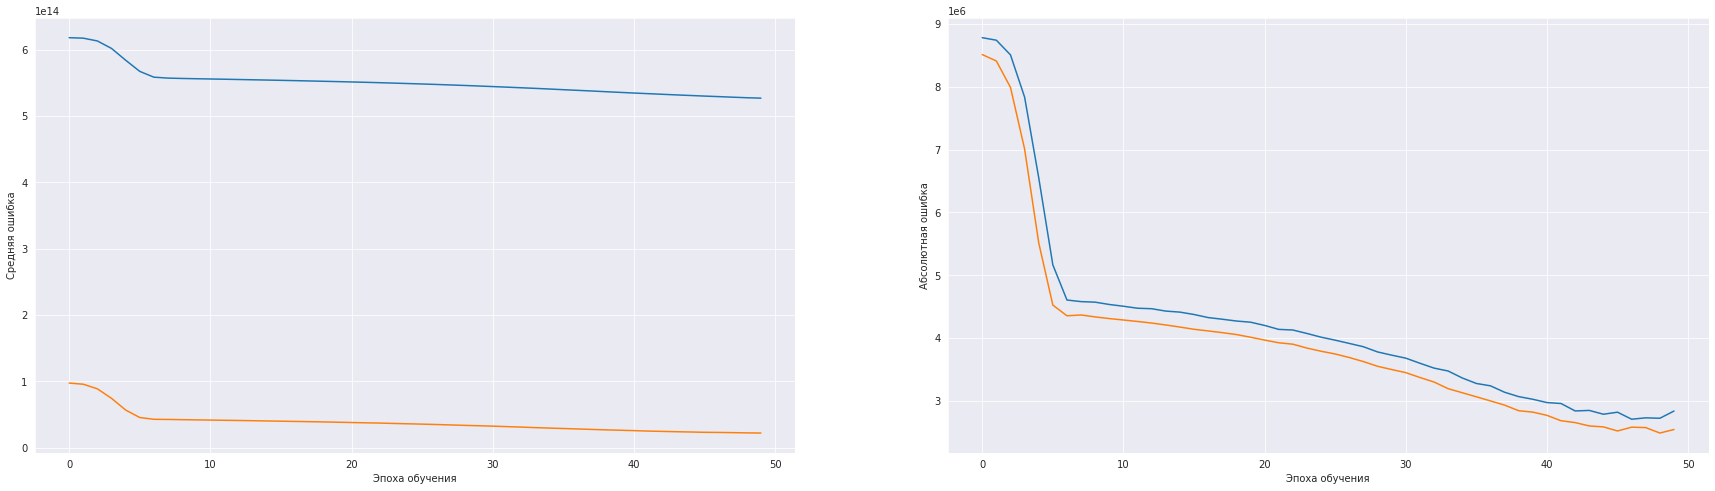

In [ ]:
worker.plot_graphic(history)

In [ ]:
worker.layers_demonstration_numeric(model)

Демонстрация работы слоев модели
Для примера возьмем случайную запись из тестовой выборки:
Пример:
 [[ 0.          1.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         51.          0.          0.          0.
   0.          1.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          1.          0.          0.
   0.          0.          1.          0.          1.          0.
   0.          0.          0.          0.          1.          0.
   0.          0.          1.          0. 

**Слой Activation (tanh)**

In [ ]:
# Создание модели с помощью Functional API
inp = Input(shape=(worker.x_train_num.shape[1],))
x = Dense(128, activation='relu') (inp)
x = Dense(32) (x)
x = Activation('tanh') (x)
out = Dense(1, activation='linear') (x)

model = Model(inp, out)

model.compile(loss='mse', optimizer=Adam(learning_rate=1e-2), metrics=['mae'])

In [ ]:
history = model.fit(worker.x_train_num,
          worker.y_train,
          batch_size=512,
          validation_data=(worker.x_test_num, worker.y_test),
          epochs=50,
          shuffle=True,
          verbose=1
          )

Epoch 1/50
35/35 [==============================] - 1s 8ms/step - loss: 618449319493632.0000 - mae: 8786266.0000 - val_loss: 97530553565184.0000 - val_mae: 8524090.0000
Epoch 2/50
35/35 [==============================] - 0s 4ms/step - loss: 618449051058176.0000 - mae: 8786255.0000 - val_loss: 97530352238592.0000 - val_mae: 8524080.0000
Epoch 3/50
35/35 [==============================] - 0s 5ms/step - loss: 618448983949312.0000 - mae: 8786242.0000 - val_loss: 97530142523392.0000 - val_mae: 8524068.0000
Epoch 4/50
35/35 [==============================] - 0s 5ms/step - loss: 618448715513856.0000 - mae: 8786232.0000 - val_loss: 97529949585408.0000 - val_mae: 8524057.0000
Epoch 5/50
35/35 [==============================] - 0s 4ms/step - loss: 618448379969536.0000 - mae: 8786220.0000 - val_loss: 97529756647424.0000 - val_mae: 8524045.0000
Epoch 6/50
35/35 [==============================] - 0s 4ms/step - loss: 618448379969536.0000 - mae: 8786207.0000 - val_loss: 97529563709440.0000 - val_mae:

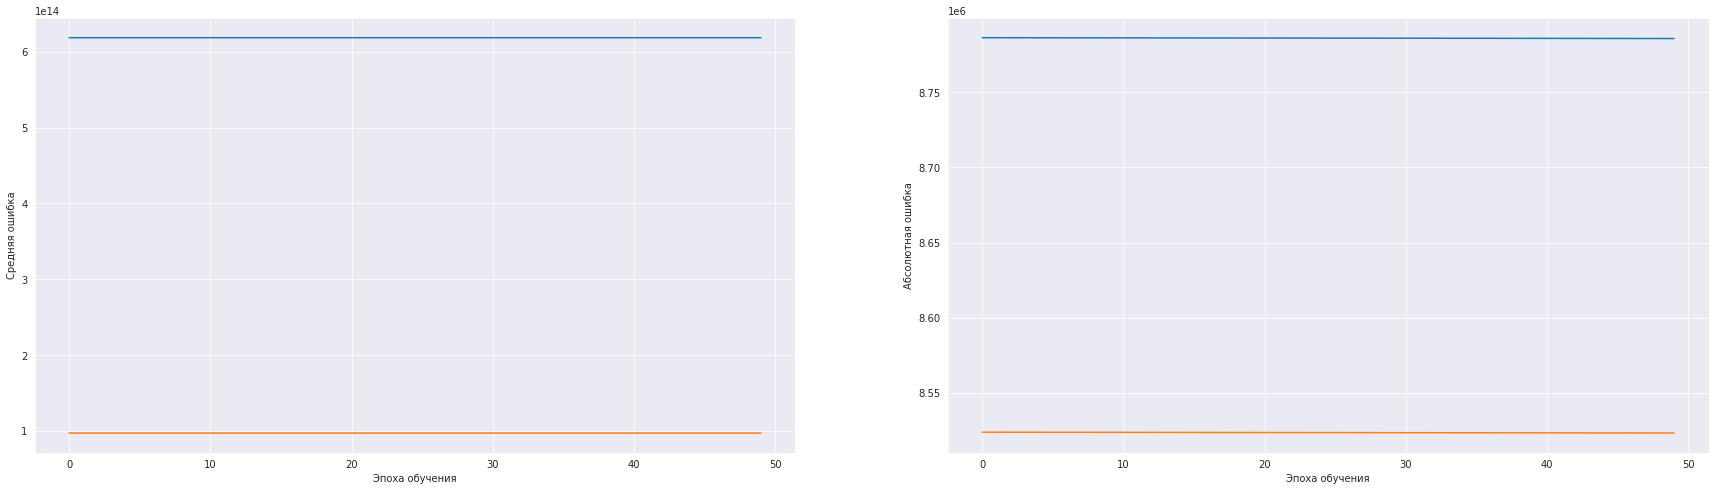

In [ ]:
worker.plot_graphic(history)

In [ ]:
worker.layers_demonstration_numeric(model)

Демонстрация работы слоев модели
Для примера возьмем случайную запись из тестовой выборки:
Пример:
 [[ 0.         1.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.        95.         0.         0.         0.
   0.         1.         0.         0.         0.         1.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         1.         0.         0.
   0.         0.         1.         0.         0.         0.
   1.         0.         0.         0.         0.         0.
   0.         1.         0.         0.         0.         0.
   0.         0.         0.         0.        

**Слой LeakyReLU**

In [ ]:
# Создание модели с помощью Functional API
inp = Input(shape=(worker.x_train_num.shape[1],))
x = Dense(128, activation='relu') (inp)
x = Dense(32) (x)
x = LeakyReLU(0.2) (x)
out = Dense(1, activation='linear') (x)

model = Model(inp, out)

model.compile(loss='mse', optimizer=Adam(learning_rate=1e-2), metrics=['mae'])

In [ ]:
history = model.fit(worker.x_train_num,
          worker.y_train,
          batch_size=512,
          validation_data=(worker.x_test_num, worker.y_test),
          epochs=50,
          shuffle=True,
          verbose=1
          )

Epoch 1/50
35/35 [==============================] - 1s 8ms/step - loss: 618392880939008.0000 - mae: 8783080.0000 - val_loss: 97270548660224.0000 - val_mae: 8509136.0000
Epoch 2/50
35/35 [==============================] - 0s 4ms/step - loss: 617194853498880.0000 - mae: 8717196.0000 - val_loss: 94511552266240.0000 - val_mae: 8348137.0000
Epoch 3/50
35/35 [==============================] - 0s 4ms/step - loss: 611221090861056.0000 - mae: 8371173.0000 - val_loss: 84794666909696.0000 - val_mae: 7743533.5000
Epoch 4/50
35/35 [==============================] - 0s 5ms/step - loss: 595921343610880.0000 - mae: 7411033.5000 - val_loss: 66296142102528.0000 - val_mae: 6375753.5000
Epoch 5/50
35/35 [==============================] - 0s 4ms/step - loss: 574948078780416.0000 - mae: 5788678.5000 - val_loss: 48762705674240.0000 - val_mae: 4796688.5000
Epoch 6/50
35/35 [==============================] - 0s 5ms/step - loss: 560401796300800.0000 - mae: 4703284.0000 - val_loss: 42893045661696.0000 - val_mae:

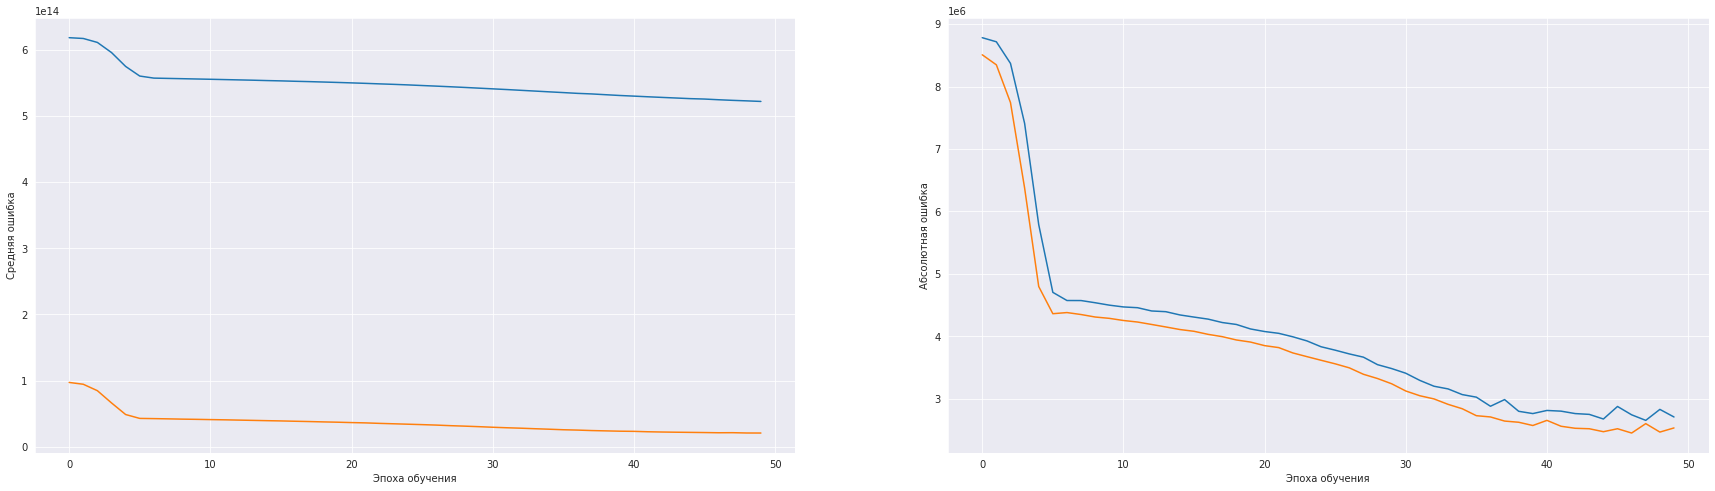

In [ ]:
worker.plot_graphic(history)

In [ ]:
worker.layers_demonstration_numeric(model)

Демонстрация работы слоев модели
Для примера возьмем случайную запись из тестовой выборки:
Пример:
 [[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.32000000e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000

**Functional API (два входа: concatenate)**

In [ ]:
input1 = Input((worker.x_train_num.shape[1],))
input2 = Input((worker.x_train_emb.shape[1],))

x1 = Dense(128, activation="relu")(input1)
x1 = Dense(10, activation="relu")(x1)
x2 = Embedding(2000, 10, input_length=worker.x_train_emb.shape[1])(input2)
x2 = Flatten() (x2)
x2 = Dense(10) (x2)

x = concatenate([x1, x2])

x = Dense(100, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2), x)

model.compile(loss='mse', optimizer=Adam(learning_rate=1e-2), metrics=['mae'])

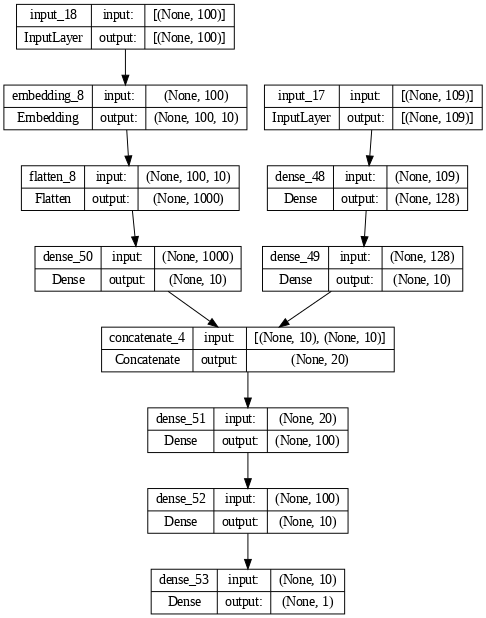

In [ ]:
utils.plot_model(model, show_shapes=True, dpi=70)

In [ ]:
history = model.fit([worker.x_train_num, worker.x_train_emb],
          worker.y_train,
          batch_size=512,
          validation_data=([worker.x_test_num, worker.x_test_emb], worker.y_test),
          epochs=50,
          shuffle=True,
          verbose=1
          )

Epoch 1/50
35/35 [==============================] - 10s 214ms/step - loss: 617828830937088.0000 - mae: 8752929.0000 - val_loss: 93020972122112.0000 - val_mae: 8259067.5000
Epoch 2/50
35/35 [==============================] - 4s 95ms/step - loss: 581676547702784.0000 - mae: 6159713.0000 - val_loss: 37169297096704.0000 - val_mae: 3947363.5000
Epoch 3/50
35/35 [==============================] - 5s 148ms/step - loss: 546217666805760.0000 - mae: 3528379.2500 - val_loss: 26980498014208.0000 - val_mae: 2854137.2500
Epoch 4/50
35/35 [==============================] - 2s 48ms/step - loss: 539770082033664.0000 - mae: 3022154.2500 - val_loss: 23503459844096.0000 - val_mae: 2440172.5000
Epoch 5/50
35/35 [==============================] - 1s 37ms/step - loss: 536900171464704.0000 - mae: 2709005.5000 - val_loss: 21444935286784.0000 - val_mae: 2721834.0000
Epoch 6/50
35/35 [==============================] - 1s 22ms/step - loss: 534870698754048.0000 - mae: 2756770.2500 - val_loss: 19529153380352.0000 -

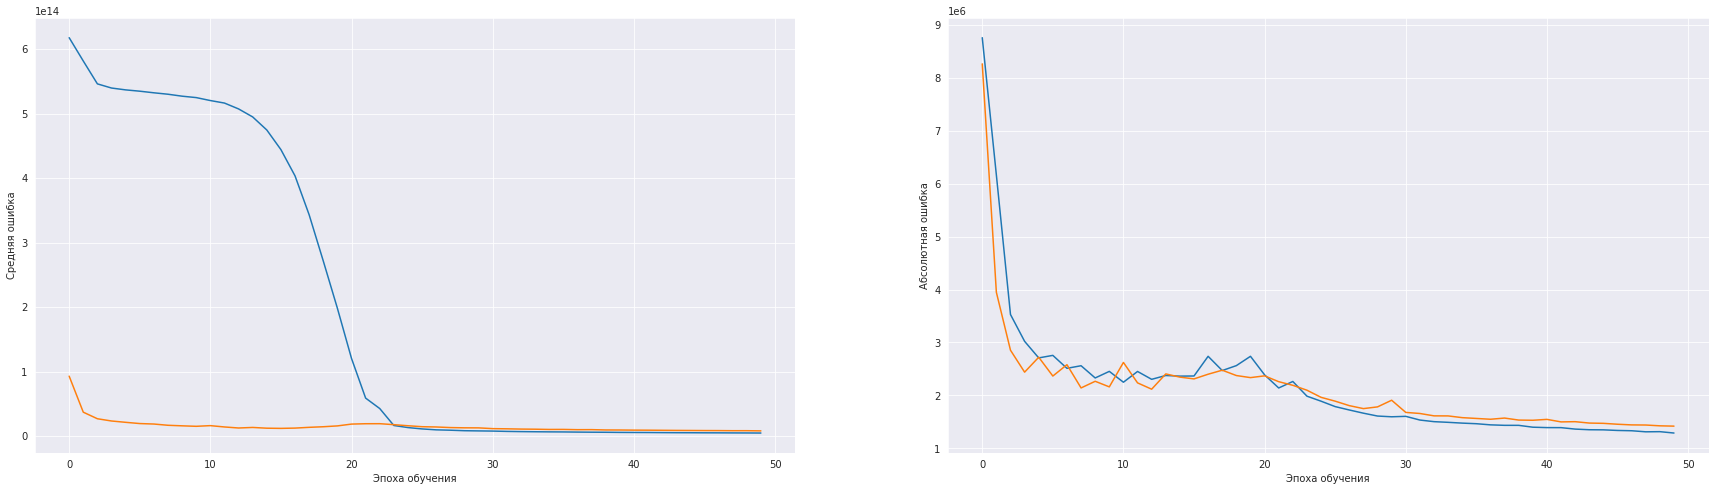

In [ ]:
worker.plot_graphic(history)

In [ ]:
worker.layers_demonstration_API(model)

Демонстрация работы слоев модели
Нейронная сеть имеет два входа. 
  Размерность первого входа: 109 элементов 
  Размерность второго входа: 100 элементов
Для примера возьмем случайную запись из тестовой выборки.
Текстовое описание:
 
корпус входящий в жк "загорье" отличительной самого высокого дома жилого комплекса является уникальный архитектурный замысел силуэт здания с объёмами жилых секций 6 до 39 этажей) которые 45- центральная часть 1 секции в ней 8 лифтов благодаря индивидуальности проекта корпус 6 стал новой высотной не только комплекса "загорье" но и всего района бирюлёво восточное прекрасные характеристики для других новостроек жк "загорье" вписаны в окружающий ландшафт района бирюлёво восточное у подножия домов жк загорье раскинулись живописные пруды и зелёный герценского парка с лота:
Цена:  7066890.0


Работа нейронной сети

  -ПЕРВЫЙ ВХОД МОДЕЛИ 
Значения поступают на 2-й слой (Dense), содержащий  128 нейронов
На выходе слоя получаем вектор из 128 значений:
+---+---+------

**Functional API (два входа: add)**

In [ ]:
input1 = Input((worker.x_train_num.shape[1],))
input2 = Input((worker.x_train_emb.shape[1],))

x1 = Dense(128, activation="relu")(input1)
x1 = Dense(10, activation="relu")(x1)
x2 = Embedding(2000, 10, input_length=worker.x_train_emb.shape[1])(input2)
x2 = Flatten() (x2)
x2 = Dense(10) (x2)

x = add([x1, x2])

x = Dense(100, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2), x)

model.compile(loss='mse', optimizer=Adam(learning_rate=1e-2), metrics=['mae'])

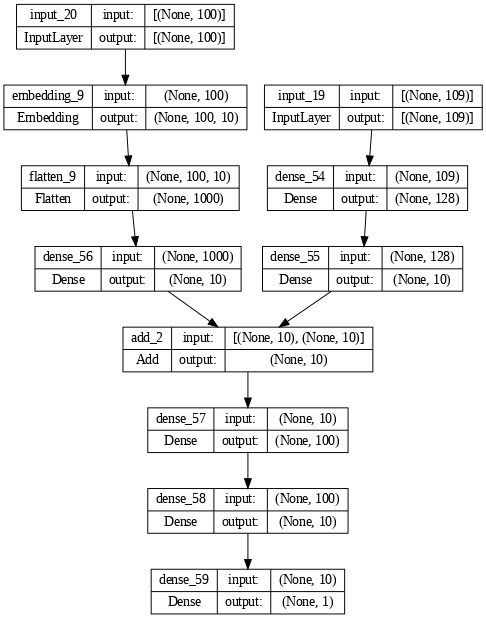

In [ ]:
utils.plot_model(model, show_shapes=True, dpi=70)

In [ ]:
history = model.fit([worker.x_train_num, worker.x_train_emb],
          worker.y_train,
          batch_size=512,
          validation_data=([worker.x_test_num, worker.x_test_emb], worker.y_test),
          epochs=50,
          shuffle=True,
          verbose=1
          )

Epoch 1/50
35/35 [==============================] - 5s 86ms/step - loss: 618303961694208.0000 - mae: 8778430.0000 - val_loss: 96482849980416.0000 - val_mae: 8463394.0000
Epoch 2/50
35/35 [==============================] - 2s 54ms/step - loss: 601834842488832.0000 - mae: 7732500.0000 - val_loss: 45415307149312.0000 - val_mae: 4496966.5000
Epoch 3/50
35/35 [==============================] - 1s 34ms/step - loss: 551720090337280.0000 - mae: 4131323.7500 - val_loss: 33163095048192.0000 - val_mae: 3423739.0000
Epoch 4/50
35/35 [==============================] - 1s 38ms/step - loss: 545377363165184.0000 - mae: 3454780.7500 - val_loss: 27896349458432.0000 - val_mae: 2923205.2500
Epoch 5/50
35/35 [==============================] - 1s 33ms/step - loss: 540931702915072.0000 - mae: 3060391.0000 - val_loss: 25308751200256.0000 - val_mae: 2931131.0000
Epoch 6/50
35/35 [==============================] - 1s 26ms/step - loss: 538568397160448.0000 - mae: 2871021.2500 - val_loss: 23969478475776.0000 - va

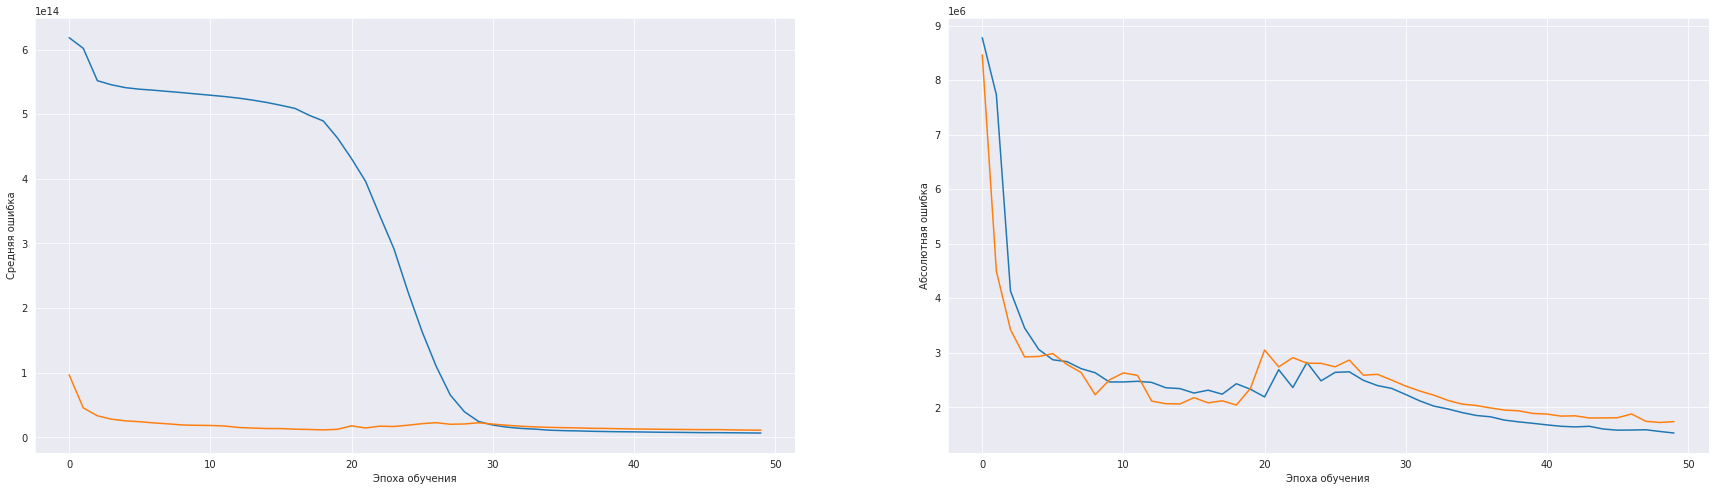

In [ ]:
worker.plot_graphic(history)

In [ ]:
worker.layers_demonstration_API(model)

Демонстрация работы слоев модели
Нейронная сеть имеет два входа. 
  Размерность первого входа: 109 элементов 
  Размерность второго входа: 100 элементов
Для примера возьмем случайную запись из тестовой выборки.
Текстовое описание:
 
прямая продажа от застройщика уютно тихо квартал "цветочные поляны" - это 14 монолитных домов по этажей квартал окружен валуевским лесопарком новой территории комплекса будут построены 2 детских сада школа и многоуровневые паркинги на первых этажах корпусов разместятся: магазины кафе салоны красоты отделения банков и многое другое квартал расположен в новомосковском ао г москвы в поселении в 16 км от жк "цветочные поляны" в 2022 году работу 3 станции метро сокольнической "филатов луг" и "ольховая" до всех станций можно будет легко добраться за минут на общественном транспорте
Цена:  4337313.0


Работа нейронной сети

  -ПЕРВЫЙ ВХОД МОДЕЛИ 
Значения поступают на 2-й слой (Dense), содержащий  128 нейронов
На выходе слоя получаем вектор из 128 значений:
+---+-

**Functional API (два входа: multiply)**

In [ ]:
input1 = Input((worker.x_train_num.shape[1],))
input2 = Input((worker.x_train_emb.shape[1],))

x1 = Dense(128, activation="relu")(input1)
x1 = Dense(10, activation="relu")(x1)
x2 = Embedding(2000, 10, input_length=worker.x_train_emb.shape[1])(input2)
x2 = Flatten() (x2)
x2 = Dense(10) (x2)

x = multiply([x1, x2])

x = Dense(100, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2), x)

model.compile(loss='mse', optimizer=Adam(learning_rate=1e-2), metrics=['mae'])

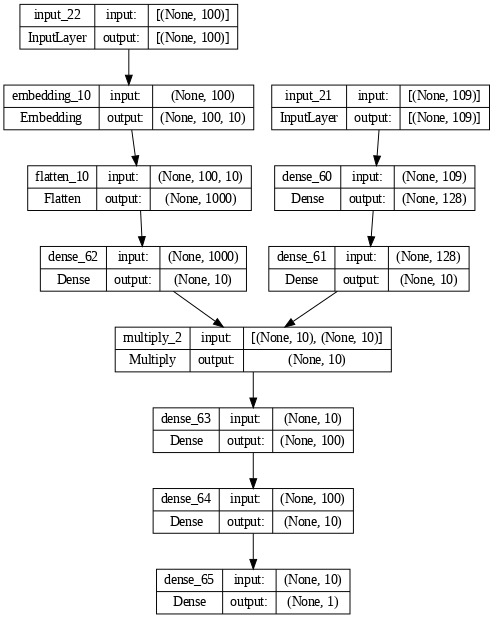

In [ ]:
utils.plot_model(model, show_shapes=True, dpi=70)

In [ ]:
history = model.fit([worker.x_train_num, worker.x_train_emb],
          worker.y_train,
          batch_size=512,
          validation_data=([worker.x_test_num, worker.x_test_emb], worker.y_test),
          epochs=50,
          shuffle=True,
          verbose=1
          )

Epoch 1/50
35/35 [==============================] - 5s 103ms/step - loss: 617037214777344.0000 - mae: 8703501.0000 - val_loss: 79527745159168.0000 - val_mae: 7388410.0000
Epoch 2/50
35/35 [==============================] - 2s 55ms/step - loss: 557187013279744.0000 - mae: 5006219.0000 - val_loss: 45679095316480.0000 - val_mae: 4732130.0000
Epoch 3/50
35/35 [==============================] - 2s 44ms/step - loss: 542257069424640.0000 - mae: 4183813.7500 - val_loss: 31306851287040.0000 - val_mae: 3550221.2500
Epoch 4/50
35/35 [==============================] - 1s 28ms/step - loss: 528379459665920.0000 - mae: 3382366.7500 - val_loss: 22656302710784.0000 - val_mae: 2798894.0000
Epoch 5/50
35/35 [==============================] - 1s 20ms/step - loss: 510316874039296.0000 - mae: 2984528.5000 - val_loss: 16167772094464.0000 - val_mae: 2392534.5000
Epoch 6/50
35/35 [==============================] - 1s 27ms/step - loss: 478005600190464.0000 - mae: 2867631.2500 - val_loss: 14434947825664.0000 - v

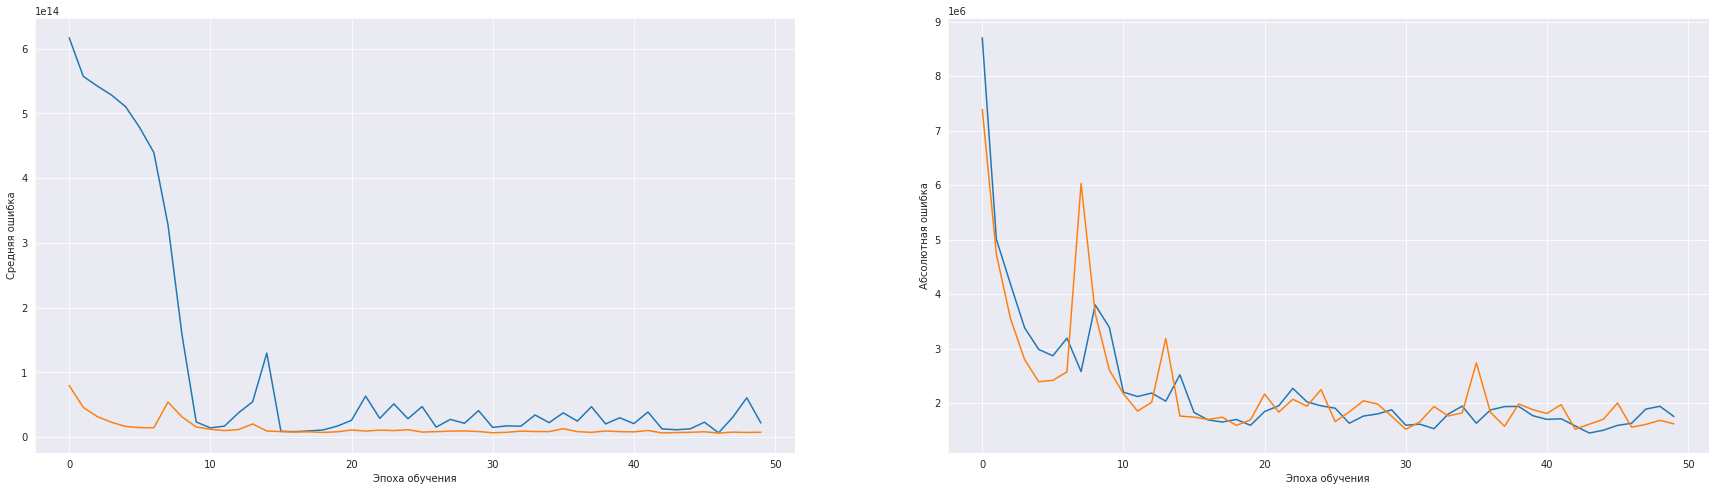

In [ ]:
worker.plot_graphic(history)

In [ ]:
worker.layers_demonstration_API(model)

Демонстрация работы слоев модели
Нейронная сеть имеет два входа. 
  Размерность первого входа: 109 элементов 
  Размерность второго входа: 100 элементов
Для примера возьмем случайную запись из тестовой выборки.
Текстовое описание:
 
к апартаменты на первом этаже с потолки 38 м свободная планировка и панорамное остекление вашего и как сделать квартиру среди современный дом по индивидуальному проекту с тип два лесопарка в метрах от собственная дом просторная входная панорамное закрытая охраняемая территория с видео в в метрах от комплекса открытие станции метро дом стоимость и на стоимость в договоре ключи на руках
Цена:  7800000.0


Работа нейронной сети

  -ПЕРВЫЙ ВХОД МОДЕЛИ 
Значения поступают на 2-й слой (Dense), содержащий  128 нейронов
На выходе слоя получаем вектор из 128 значений:
+---------+---+---+---------+---------+----------+---------+---------+---------+--------+
| 0       | 0 | 0 | 9.32073 | 0       | 3.1937   | 0       | 0       | 0       |  0     |
+---------+---+---+--